# Neural Networks for Time Series

In this notebook, we'll cover topics related to learning from time series and sequential data.

## Preamble

This lab session deals with the use of neural networks for time series classification and forecasting.
Two kinds of architectures are considered here: convolutional and recurrent models. An illustration of attention-based models is provided at the end of the lab.

## Time Series Classification using convolutional models (ConvNets)

For a start, you will load the "Trace" dataset using [`tslearn` data loading tool](https://tslearn.readthedocs.io/en/latest/gen_modules/datasets/tslearn.datasets.CachedDatasets.html#tslearn.datasets.CachedDatasets.load_dataset).

**Question #1.** What are the dimensions of the training data (`X_train`)? And what does each dimension correspond to (number of series, number of timestamps, number of features, ...)?
Also, `keras` expects class information to be encoded as one-hot vectors. Use [`to_categorical`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) to format your `y` arrays accordingly.


In [2]:
from tslearn.datasets import CachedDatasets
from keras.utils import to_categorical

data_loader = CachedDatasets()

X_train, y_train, X_test, y_test = data_loader.load_dataset("Trace")

y_train -= 1
y_test -= 1
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(X_train.shape, y_train.shape)

2023-02-10 14:31:36.490599: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(100, 275, 1) (100, 4)


**Question #2.** In the following, you will be implementing a ConvNet using keras' [`Conv1D`](https://keras.io/api/layers/convolution_layers/convolution1d/) layers.
What value should be passed to the `data_format` parameter to match `tslearn` format? Is it the default value?

**Your Answer here.**

**Question #3.** `keras` has a `Sequential` model class that allows to build models by stacking layers.
Define a model that is made of the following layers (use ReLU activation wherever it makes sense):

* a convolution layer made of 10 filters of size 3
* a pooling layer of pool size 2
* a flatten layer (that converts a time series of features into a flattened array that is suited to feed fully-connected layers)
* a fully-connected layer that has as many neurons as the number of classes in the "Trace" problem, and an adequate activation function.

Compile your model (use "Adam" optimizer) and fit it for 10 epochs.

In [3]:
from keras.models import Sequential
from keras.layers import InputLayer, Conv1D, MaxPool1D, Flatten, Dense

model = Sequential([
    InputLayer(input_shape=(275, 1)),
    Conv1D(filters=10, kernel_size=3, activation="relu"),
    MaxPool1D(pool_size=2),
    Flatten(),
    Dense(units=4, activation="softmax")
])
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
h = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)

2023-02-10 14:31:47.303370: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
2/2 [==============================] - 1s 216ms/step - loss: 1.3898 - accuracy: 0.3800 - val_loss: 1.3037 - val_accuracy: 0.3500
Epoch 2/10
2/2 [==============================] - 0s 32ms/step - loss: 1.2072 - accuracy: 0.5000 - val_loss: 1.1564 - val_accuracy: 0.4100
Epoch 3/10
2/2 [==============================] - 0s 31ms/step - loss: 1.0715 - accuracy: 0.5400 - val_loss: 1.0433 - val_accuracy: 0.4200
Epoch 4/10
2/2 [==============================] - 0s 39ms/step - loss: 0.9701 - accuracy: 0.5500 - val_loss: 0.9475 - val_accuracy: 0.4400
Epoch 5/10
2/2 [==============================] - 0s 36ms/step - loss: 0.8867 - accuracy: 0.5900 - val_loss: 0.8787 - val_accuracy: 0.5000
Epoch 6/10
2/2 [==============================] - 0s 50ms/step - loss: 0.8234 - accuracy: 0.6100 - val_loss: 0.8319 - val_accuracy: 0.5200
Epoch 7/10
2/2 [==============================] - 0s 40ms/step - loss: 0.7755 - accuracy: 0.6200 - val_loss: 0.7971 - val_accuracy: 0.4900
Epoch 8/10
2/2 [==========

**Question #4.** Plot the evolution of accuracy through epochs on both training and validation sets.

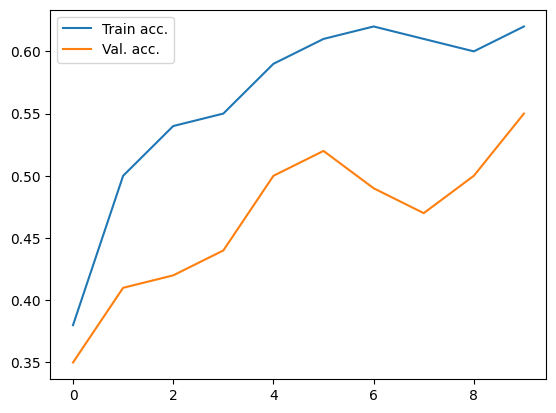

In [4]:
import matplotlib.pyplot as plt

plt.plot(h.history["accuracy"], label="Train acc.")
plt.plot(h.history["val_accuracy"], label="Val. acc.")
plt.legend();

**Question #5.** Ten epochs of training might not be sufficient, yet we do not know how many epochs would be necessary for a decent training. Set up early stopping (cf. [this callback](https://keras.io/api/callbacks/early_stopping/)) and see how long it takes before the model stops training.

In [5]:
from keras.callbacks import EarlyStopping

cb = EarlyStopping(patience=10, monitor="val_loss", restore_best_weights=True)

model = Sequential([
    InputLayer(input_shape=(275, 1)),
    Conv1D(filters=10, kernel_size=3, activation="relu"),
    MaxPool1D(pool_size=2),
    Flatten(),
    Dense(units=4, activation="softmax")
])
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
h = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, callbacks=[cb])

Epoch 1/100
2/2 [==============================] - 2s 499ms/step - loss: 1.4964 - accuracy: 0.1400 - val_loss: 1.3709 - val_accuracy: 0.4000
Epoch 2/100
2/2 [==============================] - 0s 38ms/step - loss: 1.2943 - accuracy: 0.5200 - val_loss: 1.2200 - val_accuracy: 0.4600
Epoch 3/100
2/2 [==============================] - 0s 70ms/step - loss: 1.1488 - accuracy: 0.6100 - val_loss: 1.1041 - val_accuracy: 0.4500
Epoch 4/100
2/2 [==============================] - 0s 42ms/step - loss: 1.0321 - accuracy: 0.6600 - val_loss: 1.0113 - val_accuracy: 0.4700
Epoch 5/100
2/2 [==============================] - 0s 79ms/step - loss: 0.9430 - accuracy: 0.6600 - val_loss: 0.9333 - val_accuracy: 0.4700
Epoch 6/100
2/2 [==============================] - 0s 122ms/step - loss: 0.8713 - accuracy: 0.6500 - val_loss: 0.8668 - val_accuracy: 0.4800
Epoch 7/100
2/2 [==============================] - 0s 135ms/step - loss: 0.8140 - accuracy: 0.6600 - val_loss: 0.8166 - val_accuracy: 0.4700
Epoch 8/100
2/2 [

## Recurrent neural nets

For this new part of the lab, we will use the data generated from the function below:

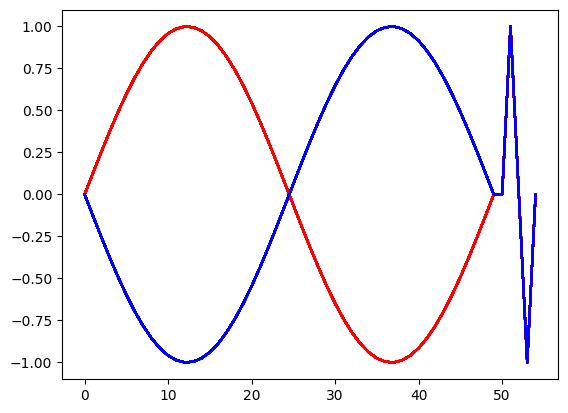

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def make_sines(n_series_per_class, length, length_padding=0):
    t = np.linspace(0, 2 * np.pi, num=length)
    X0 = .005 * np.random.randn(n_series_per_class, length + length_padding)
    X0[:, :length] = np.sin(t).reshape((1, -1))
    X0[:, length:] = np.sin(np.linspace(0, 2 * np.pi, num=length_padding))
    
    X1 = .005 * np.random.randn(n_series_per_class, length + length_padding)
    X1[:, :length] = np.sin(-t).reshape((1, -1))
    X1[:, length:] = np.sin(np.linspace(0, 2 * np.pi, num=length_padding))

    dataset = np.array([X0, X1]).reshape((2 * n_series_per_class, length + length_padding, 1))
    y = np.array([0] * n_series_per_class + [1] * n_series_per_class)

    indices = np.random.permutation(2 * n_series_per_class)
    return dataset[indices], y[indices]

np.random.seed(0)
X_train, y_train = make_sines(100, 50, length_padding=5)
X_test, y_test = make_sines(100, 50, length_padding=5)

plt.figure()
colors = ["r", "b"]
for ts, yi in zip(X_train, y_train):
    plt.plot(ts.ravel(), color=colors[yi])
plt.show()

**Question #7.** Implement your own recurrent layer (_cf._ formulas in the course) using the skeleton below and train a network
made of a single recurrent unit with a 8-dimensional hidden state followed by a fully connected layer, and evaluate its classification 
performance on the dataset provided above.

In [ ]:
from keras.layers import Layer
from keras.ops import tanh, zeros

class CustomRecurrentUnit(Layer):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim

        # List sets of parameters here
        self.w_h = self.add_weight(
            shape=(hidden_dim, hidden_dim), initializer="random_normal", trainable=True
        )
        self.b_h = self.add_weight(shape=(hidden_dim,), initializer="zeros", trainable=True)
        self.w_i = self.add_weight(
            shape=(input_dim, hidden_dim), initializer="random_normal", trainable=True
        )
        self.b_i = self.add_weight(shape=(hidden_dim,), initializer="zeros", trainable=True)
    
    def linear_hidden(self, h_t):
        return h_t @ self.w_h + self.b_h
    
    def linear_input(self, x_t):
        return x_t @ self.w_i + self.b_i
    
    def call(self, x):
        n_timestamps = x.shape[1]
        h = zeros((1, self.hidden_dim))  # Initialize h to [0, ..., 0]
        for t in range(n_timestamps):
            h = tanh(self.linear_hidden(h) + self.linear_input(x[:, t, :]))
        return h

**Question #8.** Implement a network made of a `CustomRecurrentUnit` followed by a fully-connected layer
for the classification task introduced above.
Evaluate this model both in terms of training loss and test-set accuracy (you can use the above callback to limit the amount of logging).

In [10]:
model = Sequential([
    CustomRecurrentUnit(input_dim=1, hidden_dim=32),
    Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
7/7 [==============================] - 8s 205ms/step - loss: 0.6957 - accuracy: 0.5000 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 2/100
7/7 [==============================] - 0s 11ms/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 3/100
7/7 [==============================] - 0s 11ms/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 4/100
7/7 [==============================] - 0s 12ms/step - loss: 0.6935 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 5/100
7/7 [==============================] - 0s 11ms/step - loss: 0.6935 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/100
7/7 [==============================] - 0s 11ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/100
7/7 [==============================] - 0s 11ms/step - loss: 0.6934 - accuracy: 0.4300 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 8/100
7/7 [==

**Question #9.** Update your dataset so that it includes a final padding of 15 timestamps (_cf._ signature of the `make_sines` function)
and see how it impacts performance of your model.

In [ ]:
X_train, y_train = make_sines(100, 50, length_padding=15)
X_test, y_test = make_sines(100, 50, length_padding=15)

**Question #10.** Build GRU (resp. LSTM) counterparts of the RNN-based model above.
How do they compare experimentally to the previous model?

In [11]:
from keras.layers import GRU

model = Sequential([
    GRU(units=32),
    Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
7/7 [==============================] - 3s 106ms/step - loss: 0.6951 - accuracy: 0.4700 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 2/100
7/7 [==============================] - 0s 41ms/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/100
7/7 [==============================] - 0s 41ms/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/100
7/7 [==============================] - 0s 41ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 5/100
7/7 [==============================] - 0s 40ms/step - loss: 0.6935 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/100
7/7 [==============================] - 0s 40ms/step - loss: 0.6932 - accuracy: 0.4900 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/100
7/7 [==============================] - 0s 41ms/step - loss: 0.6932 - accuracy: 0.4900 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 8/100
7/7 [==

In [12]:
from keras.layers import LSTM

model = Sequential([
    LSTM(units=32),
    Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
7/7 [==============================] - 3s 111ms/step - loss: 0.6938 - accuracy: 0.4150 - val_loss: 0.6881 - val_accuracy: 0.5000
Epoch 2/100
7/7 [==============================] - 0s 38ms/step - loss: 0.6833 - accuracy: 0.7500 - val_loss: 0.6717 - val_accuracy: 1.0000
Epoch 3/100
7/7 [==============================] - 0s 37ms/step - loss: 0.6566 - accuracy: 1.0000 - val_loss: 0.6176 - val_accuracy: 1.0000
Epoch 4/100
7/7 [==============================] - 0s 41ms/step - loss: 0.5698 - accuracy: 1.0000 - val_loss: 0.4785 - val_accuracy: 1.0000
Epoch 5/100
7/7 [==============================] - 0s 42ms/step - loss: 0.4314 - accuracy: 1.0000 - val_loss: 0.3445 - val_accuracy: 1.0000
Epoch 6/100
7/7 [==============================] - 0s 36ms/step - loss: 0.2956 - accuracy: 1.0000 - val_loss: 0.2254 - val_accuracy: 1.0000
Epoch 7/100
7/7 [==============================] - 0s 49ms/step - loss: 0.1925 - accuracy: 1.0000 - val_loss: 0.1452 - val_accuracy: 1.0000
Epoch 8/100
7/7 [==

In [ ]:
model = Sequential([
    CustomRecurrentUnit(input_dim=1, hidden_dim=32),
    Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

## Recap

**Question #11.** Come back to the "Trace" dataset used above and design a fair comparison between several convolutional and recurrent architectures to decide which one to choose for the problem at hand (feel free to play with the depth of the nets, as well as hidden representation dimensionality, etc.).

In [13]:
data_loader = CachedDatasets()
X_train, y_train, X_test, y_test = data_loader.load_dataset("Trace")
print(X_train.shape)

y_train -= 1
y_test -= 1
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


feature_extractors = {
    "Conv_1layer": Sequential([
        Conv1D(filters=25, kernel_size=5, activation="relu")
    ]),
    "Conv_2layers": Sequential([
        Conv1D(filters=25, kernel_size=5, activation="relu"),
        Conv1D(filters=25, kernel_size=5, activation="relu"),
    ]),
    "Conv_3layers": Sequential([
        Conv1D(filters=25, kernel_size=5, activation="relu"),
        Conv1D(filters=25, kernel_size=5, activation="relu"),
        Conv1D(filters=25, kernel_size=5, activation="relu"),
    ]),
    "LSTM_1layer": Sequential([
        LSTM(units=25, return_sequences=True)
    ]),
    "LSTM_2layers": Sequential([
        LSTM(units=25, return_sequences=True),
        LSTM(units=25, return_sequences=True),
    ]),
    "LSTM_3layers": Sequential([
        LSTM(units=25, return_sequences=True),
        LSTM(units=25, return_sequences=True),
        LSTM(units=25, return_sequences=True)
    ]),
}

for name, f in feature_extractors.items():
    model = Sequential([
        f,
        Flatten(),
        Dense(units=4, activation="softmax")
    ])
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    h = model.fit(X_train, y_train, epochs=10, verbose=False)
    print(name, model.evaluate(X_test, y_test))

(100, 275, 1)
4/4 [==============================] - 0s 3ms/step - loss: 0.8124 - accuracy: 0.5500
Conv_1layer [0.8123898506164551, 0.550000011920929]
4/4 [==============================] - 0s 3ms/step - loss: 0.6361 - accuracy: 0.6100
Conv_2layers [0.6361228823661804, 0.6100000143051147]
4/4 [==============================] - 0s 6ms/step - loss: 0.6882 - accuracy: 0.5800
Conv_3layers [0.6881691217422485, 0.5799999833106995]
4/4 [==============================] - 1s 38ms/step - loss: 0.8049 - accuracy: 0.4700
LSTM_1layer [0.8049086928367615, 0.4699999988079071]
4/4 [==============================] - 1s 39ms/step - loss: 0.8502 - accuracy: 0.4800
LSTM_2layers [0.8501598238945007, 0.47999998927116394]
4/4 [==============================] - 1s 65ms/step - loss: 0.6810 - accuracy: 0.5000
LSTM_3layers [0.6810304522514343, 0.5]


## Toy seq2seq task

We now turn our focus on attention-based models.
For a start, have a look at the data produced by the following `gen_data` function.
The task at hand is to predict the output sequence from its corresponding input one.

In [19]:
import numpy as np
import matplotlib.pyplot as plt


def make_series(positions, heights, shapes, size):
    series = np.zeros((size, ))
    for p, h, s in zip(positions, heights, shapes):
        if s == "r":
            series[p-5:p+5] = h
        else:
            series[p-5:p] = np.linspace(start=0., stop=h, num=5)
            series[p:p+5] = np.linspace(stop=0., start=h, num=5)
    return series.reshape((-1, 1))
    

def gen_data(n_samples, noise_level=.1):
    inputs, outputs = [], []
    shapes = np.array(["t", "r"] * 2)
    n_shapes = len(shapes)
    
    sz = 100
    region_width = sz // n_shapes
    
    for i in range(n_samples):
        np.random.shuffle(shapes)
        index_high_t = np.random.choice(np.where(shapes == "t")[0], size=1)[0]
        index_high_r = np.random.choice(np.where(shapes == "r")[0], size=1)[0]
        
        base_input_series = np.random.randn(sz, 1) * noise_level
        heights = []
        positions = []
        for idx_shape in range(n_shapes):
            pos = idx_shape * region_width + np.random.randint(low=5, high=region_width - 5)
            height = (.5 + np.random.rand(1)[0]) * 10.
            if idx_shape in [index_high_r, index_high_t]:
                height += 20.
            heights.append(height)
            positions.append(pos)
        input_series = np.random.randn(sz, 1) * noise_level + make_series(positions, heights, shapes, sz)
        
        normalized_heights = np.array(heights)
        for s in ["t", "r"]:
            normalized_heights[shapes == s] = normalized_heights[shapes == s].mean()
        output_series = np.random.randn(sz, 1) * noise_level + make_series(positions, normalized_heights, shapes, sz)
        inputs.append(input_series)
        outputs.append(output_series)
            
    return np.array(inputs), np.array(outputs)

np.random.seed(0)
inputs, outputs = gen_data(1000)
test_inputs, test_outputs = gen_data(10)

**Question #12.** Visualize the first 6 input/output pairs (each in one subfigure). Can you guess how the height of output motifs is computed?
Why would this data better suited to attention-based models than convolutional ones, for example?

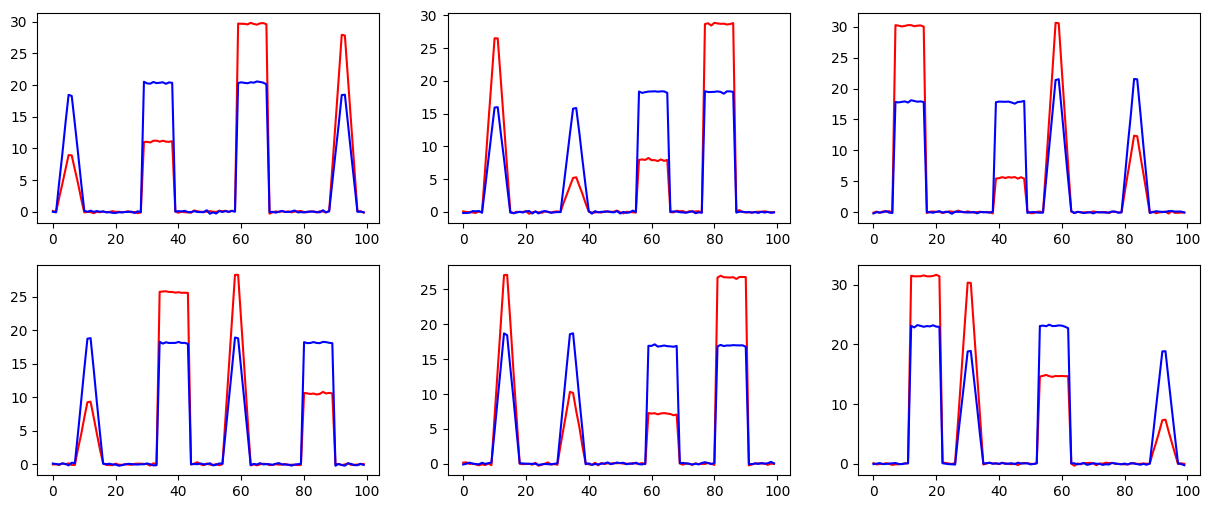

In [20]:
plt.figure(figsize=(15, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.plot(inputs[i, :, 0], color="r")
    plt.plot(outputs[i, :, 0], color="b")

**Question #13.** Check how a model made of a stack of 5 convolutional layers (use 64 filters in all layers except the last one) performs on this task. What loss function should you use?

In [21]:
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=5, padding="same", activation="relu"),
    Conv1D(filters=64, kernel_size=5, padding="same", activation="relu"),
    Conv1D(filters=64, kernel_size=5, padding="same", activation="relu"),
    Conv1D(filters=64, kernel_size=5, padding="same", activation="relu"),
    Conv1D(filters=1, kernel_size=5, padding="same", activation="relu"),
])
cnn_model.compile(loss="mse", optimizer="adam")
cnn_h = cnn_model.fit(inputs, outputs, validation_data=(test_inputs, test_outputs), epochs=20)

Epoch 1/20
32/32 [==============================] - 2s 27ms/step - loss: 30.5481 - val_loss: 24.0609
Epoch 2/20
32/32 [==============================] - 1s 23ms/step - loss: 21.3212 - val_loss: 20.4632
Epoch 3/20
32/32 [==============================] - 1s 23ms/step - loss: 12.6445 - val_loss: 6.4233
Epoch 4/20
32/32 [==============================] - 1s 22ms/step - loss: 4.1987 - val_loss: 3.4889
Epoch 5/20
32/32 [==============================] - 1s 25ms/step - loss: 2.3838 - val_loss: 2.0252
Epoch 6/20
32/32 [==============================] - 1s 21ms/step - loss: 1.6322 - val_loss: 2.8174
Epoch 7/20
32/32 [==============================] - 1s 20ms/step - loss: 1.4430 - val_loss: 1.4398
Epoch 8/20
32/32 [==============================] - 1s 34ms/step - loss: 1.3914 - val_loss: 1.5797
Epoch 9/20
32/32 [==============================] - 1s 27ms/step - loss: 1.0996 - val_loss: 1.9495
Epoch 10/20
32/32 [==============================] - 1s 28ms/step - loss: 1.1642 - val_loss: 1.5134
Epoc

1/1 [==============================] - 0s 144ms/step


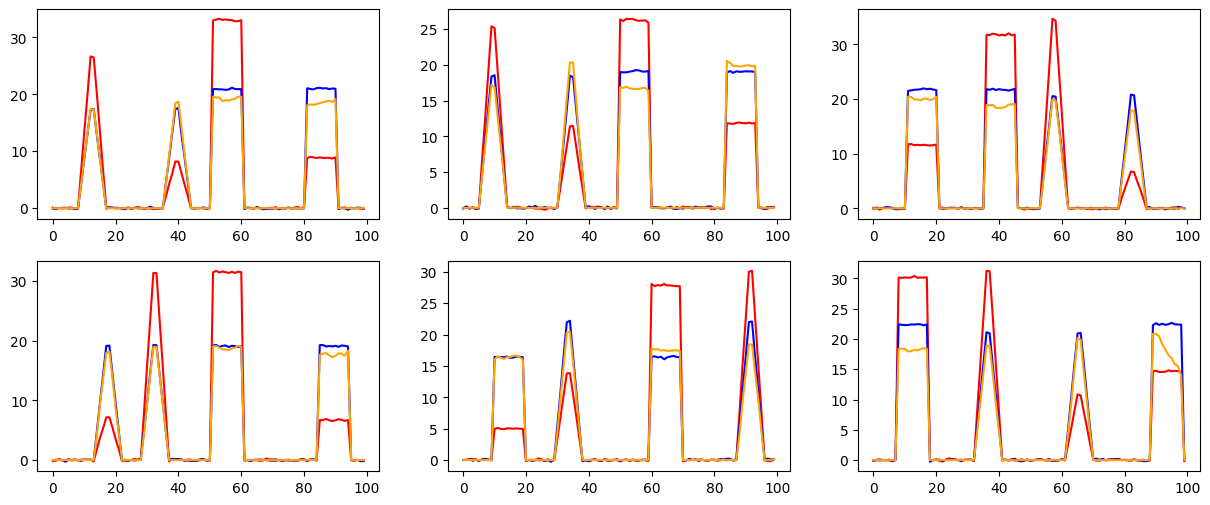

In [22]:
preds = cnn_model.predict(test_inputs)
plt.figure(figsize=(15, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.plot(test_inputs[i, :, 0], color="r")
    plt.plot(test_outputs[i, :, 0], color="b")
    plt.plot(preds[i, :, 0], color="orange")

**Question #14.** Below is the definition of a multi-head self attention layer class. Use this class to replace the 3rd convolution in your model above by a **single-head self-attention layer** that would output a 64-dimensional time series.

In [23]:
from keras.layers import MultiHeadAttention

class MultiHeadSelfAttention(MultiHeadAttention):
    def __init__(self, num_heads, key_dim, dropout=0.):
        super().__init__(num_heads, key_dim, dropout=dropout)

    def call(self, x, return_attention_scores=False):
        return super().call(x, x, return_attention_scores=return_attention_scores)

In [25]:
attn_model = Sequential([
    Conv1D(filters=64, kernel_size=5, padding="same", activation="relu"),
    Conv1D(filters=64, kernel_size=5, padding="same", activation="relu"),
    MultiHeadSelfAttention(num_heads=1, key_dim=64),
    Conv1D(filters=64, kernel_size=5, padding="same", activation="relu"),
    Conv1D(filters=1, kernel_size=5, padding="same", activation="relu"),
])
attn_model.compile(loss="mse", optimizer="adam")
attn_h = attn_model.fit(inputs, outputs, validation_data=(test_inputs, test_outputs), epochs=20)

Epoch 1/20
32/32 [==============================] - 3s 48ms/step - loss: 42.3037 - val_loss: 6.4548
Epoch 2/20
32/32 [==============================] - 1s 43ms/step - loss: 4.6265 - val_loss: 3.9074
Epoch 3/20
32/32 [==============================] - 1s 43ms/step - loss: 3.5562 - val_loss: 3.2643
Epoch 4/20
32/32 [==============================] - 1s 43ms/step - loss: 2.3877 - val_loss: 1.6397
Epoch 5/20
32/32 [==============================] - 1s 42ms/step - loss: 1.3113 - val_loss: 0.9594
Epoch 6/20
32/32 [==============================] - 2s 48ms/step - loss: 1.0763 - val_loss: 0.9482
Epoch 7/20
32/32 [==============================] - 2s 54ms/step - loss: 0.9515 - val_loss: 0.7824
Epoch 8/20
32/32 [==============================] - 2s 65ms/step - loss: 0.9331 - val_loss: 0.8557
Epoch 9/20
32/32 [==============================] - 1s 45ms/step - loss: 0.8705 - val_loss: 0.7473
Epoch 10/20
32/32 [==============================] - 2s 68ms/step - loss: 0.8883 - val_loss: 0.9019
Epoch 11

**Question #15.** Compare both models in terms of validation loss.

In [ ]:
plt.plot(cnn_h.history["val_loss"], label="CNN model")
plt.plot(attn_h.history["val_loss"], label="Attention-based model")
plt.legend();

**Question #16.** Use test data for qualitative inspection of the produced outputs.

1/1 [==============================] - 0s 120ms/step


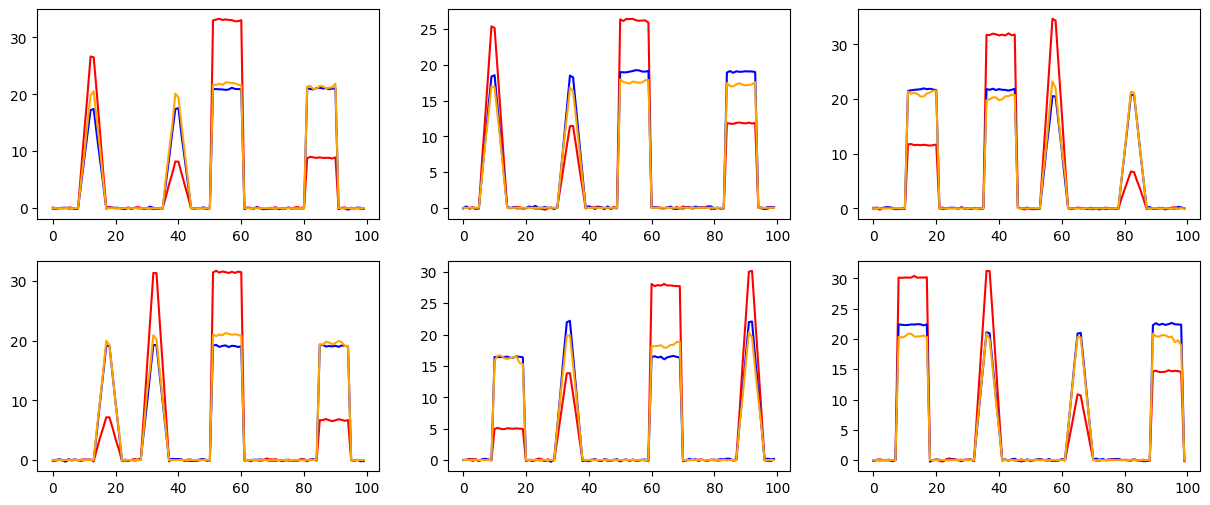

In [26]:
preds = model.predict(test_inputs)
plt.figure(figsize=(15, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.plot(test_inputs[i, :, 0], color="r")
    plt.plot(test_outputs[i, :, 0], color="b")
    plt.plot(preds[i, :, 0], color="orange")

**Question #17.** Use the code below to visualize average attention scores for the first 3 test series.

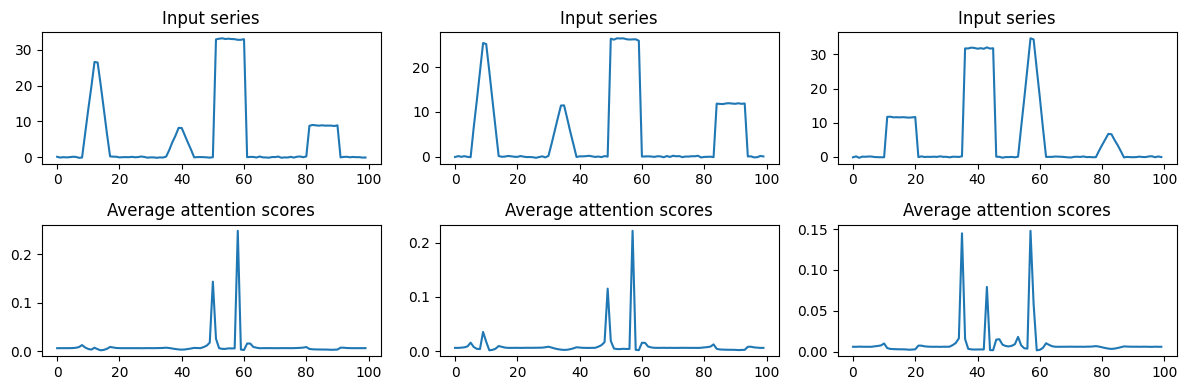

In [27]:
from keras.models import Sequential

def visualize_average_attention_scores(model, index_of_attention_layer, time_series):
    sub_model = Sequential(model.layers[:index_of_attention_layer])
    input_features = sub_model(time_series)
    att_layer = model.layers[index_of_attention_layer]
    _, weights = att_layer(input_features, return_attention_scores=True)

    plt.figure(figsize=(4*len(time_series), 4))
    for idx, ts in enumerate(time_series):
        plt.subplot(2, len(time_series), idx + 1)
        plt.plot(ts.ravel())
        plt.title("Input series")
        plt.subplot(2, len(time_series), len(time_series) + idx + 1)
        plt.plot(weights[idx, 0].numpy().mean(axis=0))
        plt.title("Average attention scores")
    plt.tight_layout()

visualize_average_attention_scores(model, 2, test_inputs[:3])